In [2]:
pip install --upgrade h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ashok\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_iris
import pandas as pd
import h5py
from PIL import Image
from scipy import ndimage
import copy
np.random.seed(1)

In [ ]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*0.001
        parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [3]:
def linear_forward(A, W, b):
    Z=np.dot(W,A)+b
    cache = (A, W, b)
    
    return Z, cache

In [4]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    cache=z
    return s,cache

In [5]:
def relu(z):
    cache=z
    r=np.maximum(0,z)
    return r,cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache=linear_forward(A_prev,W,b)
        A, activation_cache=sigmoid(Z)
       
    
    elif activation == "relu":
       
        Z, linear_cache=linear_forward(A_prev,W,b)
        A, activation_cache=relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters):
 
    caches = []
    A = X
    L = len(parameters) // 2                 
    for l in range(1, L):
        A_prev = A 
        A, cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],activation="relu")
        caches.append(cache)
        
    AL, cache=linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],activation="sigmoid")
    caches.append(cache)
          
    return AL, caches

In [ ]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost= -np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))/m
    
    
    cost = np.squeeze(cost)     
    
    return cost

In [9]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW=np.dot(dZ,cache[0].T)/m
    db= np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(cache[1].T,dZ)

    
    return dA_prev, dW, db

In [69]:
def sigmoid_backward(dA,act_cache,Y):
    Z=act_cache
    A= 1/(1+np.exp(-Z))
    dZ= dA*A*(1-A)
    assert(dZ.shape==Z.shape)
    return dZ

In [11]:
def relu_backward(dA,act_cache):
    Z=act_cache
    
    dZ = np.array(dA,copy=True)
    dZ[Z <= 0] = 0
    assert(dZ.shape==Z.shape)
    return dZ

In [12]:
def linear_activation_backward(dA, cache, activation,Y):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ=relu_backward(dA,activation_cache)
        dA_prev,dW,db=linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ=sigmoid_backward(dA,activation_cache,Y)
        dA_prev,dW,db=linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [13]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL=-(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    current_cache=caches[L-1]
    dA_prev_temp,dW_temp,db_temp=linear_activation_backward(dAL,current_cache,'sigmoid',Y)
    grads["dA"+str(L-1)]=dA_prev_temp
    grads["dW"+str(L)]=dW_temp
    grads["db"+str(L)]=db_temp
    
    # Loop from l=L-2 to l=0
    for l in range(L-2,-1,-1):
        current_cache=caches[l]
        dA_prev_temp,dW_temp,db_temp=linear_activation_backward(grads["dA"+str(l+1)],current_cache,'relu',Y)
        grads["dA"+str(l)]=dA_prev_temp
        grads["dW"+str(l+1)]=dW_temp
        grads["db"+str(l+1)]=db_temp

    return grads

In [14]:
def update_parameters(params, grads, learning_rate):
   
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W"+str(l+1)]= parameters["W"+str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)]= parameters["b"+str(l+1)]-learning_rate*grads["db"+str(l+1)]
    return parameters

In [15]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost=False):

    np.random.seed(1)
    costs = []                         
    parameters=initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL,caches=L_model_forward(X,parameters)
        cost= compute_cost(AL,Y)
        grads=L_model_backward(AL,Y,caches)
        parameters=update_parameters(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.show()
    return parameters, costs

In [33]:
data=pd.read_csv('mushroom_cleaned.csv')

In [34]:
data.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
X=data.iloc[:,:-1]
Y=data.iloc[:,-1]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)


In [ ]:
def load_data():
    

    train_x_orig = np.array(X_train)  
    train_y = np.array(Y_train)  

    test_x_orig = np.array(X_test)  
    test_y = np.array(Y_test) 
    train_y = train_y.reshape((1, train_y.shape[0]))  
    test_y = test_y.reshape((1, test_y.shape[0]))  

    return train_x_orig, train_y, test_x_orig, test_y

In [47]:
train_x_orig, train_y, test_x_orig, test_y= load_data()

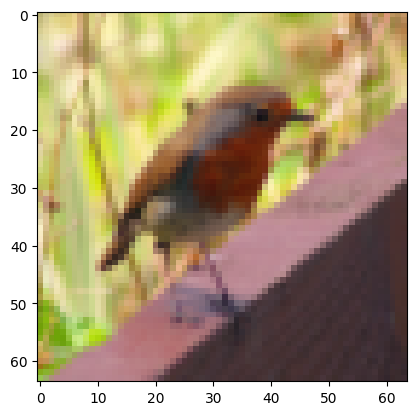

In [48]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 43228
Number of testing examples: 10807
Each image is of size: (8, 8, 3)
train_x_orig shape: (43228, 8)
train_y shape: (1, 43228)
test_x_orig shape: (10807, 8)
test_y shape: (1, 10807)


In [ ]:
train_x = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x= test_x_orig.reshape(test_x_orig.shape[0], -1).T



train_x's shape: (8, 43228)
test_x's shape: (8, 10807)
43228


In [53]:
layers_dims = [8, 10,7,5, 1]

Cost after iteration 0: 0.6931472916047177
Cost after iteration 100: 0.6911749523141909
Cost after iteration 200: 0.6899790928289292
Cost after iteration 300: 0.6892536130481566
Cost after iteration 400: 0.6888132015555647
Cost after iteration 500: 0.6885456530183849
Cost after iteration 600: 0.6883829998474792
Cost after iteration 700: 0.6882840358542683
Cost after iteration 800: 0.6882237684459748
Cost after iteration 900: 0.6881870215597234
Cost after iteration 1000: 0.6881645762184706
Cost after iteration 1100: 0.6881508267299596
Cost after iteration 1200: 0.6881423637390144
Cost after iteration 1300: 0.6881371126852769
Cost after iteration 1400: 0.6881338091614301
Cost after iteration 1500: 0.6881316792951699
Cost after iteration 1600: 0.6881302530428516
Cost after iteration 1700: 0.6881292446276495
Cost after iteration 1800: 0.6881284744665112
Cost after iteration 1900: 0.6881278281517038
Cost after iteration 2000: 0.6881272318315965
Cost after iteration 2100: 0.6881266351719749


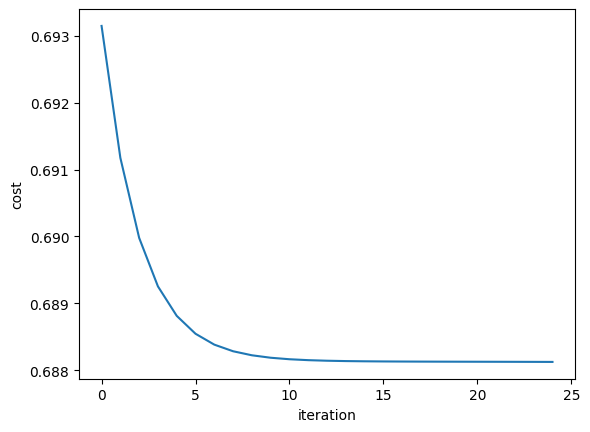

In [54]:
parameters,cost=L_layer_model(train_x,train_y,layers_dims,0.01,num_iterations=2500
                              ,print_cost=True)

In [ ]:
def predict(train_x, train_y, parameters):

    A=train_x
    L = len(parameters) // 2                  
    for l in range(1, L):
        A_prev = A 
        A, cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],activation="relu")
        
    AL, cache=linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],activation="sigmoid")

    m=train_x.shape[1]
    Y_prediction = np.zeros((1, m))
    for i in range(A.shape[1]):
        
        if AL[0,i]>=0.5:
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
        
      
    accuracy = np.mean(Y_prediction == train_y)
   
    return accuracy

In [56]:
acc=predict(train_x, train_y, parameters)
print(acc)

0.5500370130470991


In [137]:
print(len(parameters))

10


In [ ]:
def initialize_parameters(n_x, n_h, n_y):    
    np.random.seed(1)
    
    W1=np.random.randn(n_h,n_x)*0.01
    b1=np.zeros((n_h,1))
    W2=np.random.randn(n_y,n_h)*0.01
    b2=np.zeros((n_y,1))
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    
    np.random.seed(1)
    grads = {}
    costs = []                             
    m = X.shape[1]                           
    (n_x, n_h, n_y) = layers_dims
    
    parameters=initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):

        A1,cache1=linear_activation_forward(X,W1,b1,'relu')
        A2,cache2=linear_activation_forward(A1,W2,b2,'sigmoid')
       
        cost=compute_cost(A2,Y)
        
        
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1,dW2,db2=linear_activation_backward(dA2,cache2,'sigmoid',Y)
        dA0,dW1,db1=linear_activation_backward(dA1,cache1,'relu',Y)
     
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
       
        parameters=update_parameters(parameters,grads,learning_rate)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost after iteration 0: 0.6971067489475794
Cost after iteration 100: 0.6792177131105648
Cost after iteration 200: 0.6768213757912904
Cost after iteration 300: 0.6739511576436252
Cost after iteration 400: 0.6722249045098362
Cost after iteration 500: 0.6709828358172152
Cost after iteration 600: 0.6701201890198946
Cost after iteration 700: 0.6694993626403616
Cost after iteration 800: 0.6691274699654456
Cost after iteration 900: 0.6688399435751792
Cost after iteration 1000: 0.6686989317362355
Cost after iteration 1100: 0.6685762626268522
Cost after iteration 1200: 0.6684948785936531
Cost after iteration 1300: 0.6685338720814471
Cost after iteration 1400: 0.6685895463784931
Cost after iteration 1500: 0.6686169412100993
Cost after iteration 1600: 0.6687350069049544
Cost after iteration 1700: 0.6688813615348967
Cost after iteration 1800: 0.669002074139762
Cost after iteration 1900: 0.6691524628507262
Cost after iteration 2000: 0.6693022017638722
Cost after iteration 2100: 0.6694108439136132
C

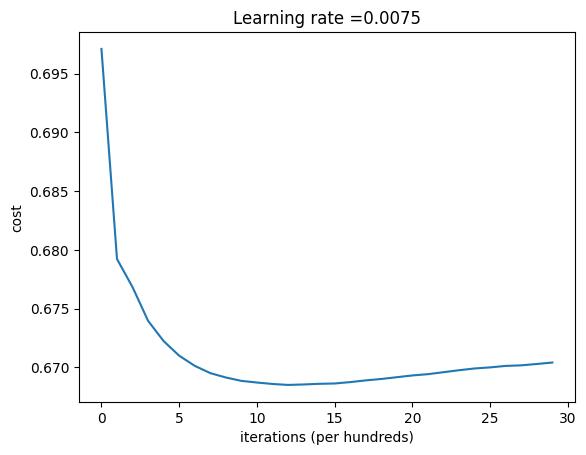

In [79]:
parameters_1,costs_1=two_layer_model(train_x, train_y, [8,7,1], learning_rate = 0.0075, num_iterations = 3000, print_cost=True)
plot_costs(costs_1,0.0075)